# Import Libraries

In [270]:
import pandas as pd
import numpy as np

import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC



# Load Dataset

In [271]:
raw_sentiment_df = pd.read_csv("sentiment_with_spy.csv")

In [272]:
raw_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4278 entries, 0 to 4277
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   4278 non-null   object 
 1   close                  4278 non-null   float64
 2   compound_mean          3507 non-null   float64
 3   compound_max           3507 non-null   float64
 4   compound_min           3507 non-null   float64
 5   headline_count         3507 non-null   float64
 6   headline               3507 non-null   object 
 7   compound_z             3503 non-null   float64
 8   final_score            3507 non-null   float64
 9   too_few_headlines      3507 non-null   object 
 10  conflicting            3507 non-null   object 
 11  sentiment_signal       3507 non-null   object 
 12  spy_return             4277 non-null   float64
 13  final_score_lag1       3507 non-null   float64
 14  sentiment_signal_lag1  3507 non-null   object 
 15  sent

In [273]:
sentiment_df = raw_sentiment_df.copy()

In [274]:
# Identify all object (categorical / string) columns
object_cols = sentiment_df.select_dtypes(include='object').columns.tolist()

print("Object columns:", object_cols)

# Display unique values for each object column
for col in object_cols:
    print(f"\n--- {col} ---")
    print(sentiment_df[col].unique())


Object columns: ['date', 'headline', 'too_few_headlines', 'conflicting', 'sentiment_signal', 'sentiment_signal_lag1', 'sentiment_bucket']

--- date ---
['2008-01-02' '2008-01-03' '2008-01-04' ... '2024-12-26' '2024-12-27'
 '2024-12-30']

--- headline ---
['JPMorgan Predicts 2008 Will Be "Nothing But Net" || Dow Tallies Biggest First-session-of-year Point Drop Ever || 2008 predictions for the S&P 500'
 'U.S. Stocks Higher After Economic Data, Monsanto Outlook' nan ...
 "S&P 500 Price Forecast â€“ Stock Market Continues to Consolidate || Stock Market Today: S&P 500 in record close as Nvidia-fueled tech rally continues || Evercore ISI's Julian Emanuel explains why he's sticking to his S&P 500 target of 4750 || Stock Market News for Feb 29, 2024 || S&P 500: 2 Stocks Turn $10,000 Into $17,214 In 2 Months || Nasdaq Index, Dow Jones, S&P 500 News: Mixed Earnings Impacting Ahead of PCE Report || Nasdaq notches first record high close since 2021 || Merits and demerits of stock pundits || Someth

# Data Cleaning

## Check Data Types

In [275]:
sentiment_df.dtypes

date                      object
close                    float64
compound_mean            float64
compound_max             float64
compound_min             float64
headline_count           float64
headline                  object
compound_z               float64
final_score              float64
too_few_headlines         object
conflicting               object
sentiment_signal          object
spy_return               float64
final_score_lag1         float64
sentiment_signal_lag1     object
sentiment_bucket          object
dtype: object

## Drop rows

In [276]:
# Drop rows with too few headlines
sentiment_df = sentiment_df[sentiment_df['too_few_headlines'] != True]


## Forward fill rows

In [277]:
# Forward-fill sentiment for days with no news but market is open
sentiment_cols = [
    'compound_mean', 'compound_max', 'compound_min',
    'compound_z', 'final_score', 'headline_count'
]

In [278]:
# Count missing values BEFORE ffill
na_before = sentiment_df[sentiment_cols].isna().sum()

In [279]:
sentiment_df[sentiment_cols] = sentiment_df[sentiment_cols].fillna(method= 'ffill')

C:\Users\malcolm\AppData\Local\Temp\ipykernel_8972\2140158068.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment_df[sentiment_cols] = sentiment_df[sentiment_cols].fillna(method= 'ffill')


In [280]:
# Forward fill (again, but don't assign)
temp = sentiment_df[sentiment_cols].fillna('ffill')

# Count missing values AFTER ffill
na_after = temp.isna().sum()

# How many were filled?
filled = na_before - na_after

print("Missing BEFORE:\n", na_before)
print("\nMissing AFTER:\n", na_after)
print("\nTotal forward-filled values:\n", filled)

Missing BEFORE:
 compound_mean     771
compound_max      771
compound_min      771
compound_z        772
final_score       771
headline_count    771
dtype: int64

Missing AFTER:
 compound_mean     0
compound_max      0
compound_min      0
compound_z        0
final_score       0
headline_count    0
dtype: int64

Total forward-filled values:
 compound_mean     771
compound_max      771
compound_min      771
compound_z        772
final_score       771
headline_count    771
dtype: int64


In [281]:
# conflicting: True/False/nan → 1/0
sentiment_df['conflicting'] = sentiment_df['conflicting'].fillna(False).astype(int)

# sentiment_signal: buy/hold/sell → +1 / 0 / -1
sentiment_df['sentiment_signal'] = sentiment_df['sentiment_signal'].map({
    'buy': 1,
    'hold': 0,
    'sell': -1
}).fillna(0)

sentiment_df['sentiment_signal_lag1'] = sentiment_df['sentiment_signal_lag1'].map({
    'buy': 1,
    'hold': 0,
    'sell': -1
}).fillna(0)


# sentiment_bucket: bullish/neutral/bearish → +1 / 0 / -1
sentiment_df['sentiment_bucket'] = sentiment_df['sentiment_bucket'].map({
    'bullish': 1,
    'neutral': 0,
    'bearish': -1
}).fillna(0)

sentiment_df['too_few_headlines'] = sentiment_df['too_few_headlines'].fillna(False).astype(int)


# Convert date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Sort by date
sentiment_df = sentiment_df.sort_values('date').reset_index(drop=True)


C:\Users\malcolm\AppData\Local\Temp\ipykernel_8972\1189075467.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sentiment_df['conflicting'] = sentiment_df['conflicting'].fillna(False).astype(int)
C:\Users\malcolm\AppData\Local\Temp\ipykernel_8972\1189075467.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sentiment_df['too_few_headlines'] = sentiment_df['too_few_headlines'].fillna(False).astype(int)


# Feature engineering

## Lagged Features

In [282]:

# Lag 1 return
sentiment_df['spy_return_lag1'] = sentiment_df['spy_return'].shift(1)

# Lag 1 sentiment signal
sentiment_df['sentiment_signal_lag1'] = sentiment_df['sentiment_signal'].shift(1)

# Lag 1 final_score
sentiment_df['final_score_lag1'] = sentiment_df['final_score'].shift(1)


# Sentiment volatility: difference between high and low sentiment
sentiment_df['sentiment_vol'] = (
    sentiment_df['compound_max'] - sentiment_df['compound_min']
)

# Change in news intensity (headline count delta)
sentiment_df['headline_count_change'] = (
    sentiment_df['headline_count'] - sentiment_df['headline_count'].shift(1)
)

# Rolling sentiment averages (3-day and 7-day windows)
sentiment_df['compound_mean_3d'] = sentiment_df['compound_mean'].rolling(3).mean()
sentiment_df['compound_mean_7d'] = sentiment_df['compound_mean'].rolling(7).mean()

# Rolling headline volume (3-day and 7-day windows)
sentiment_df['headline_count_3d'] = sentiment_df['headline_count'].rolling(3).mean()
sentiment_df['headline_count_7d'] = sentiment_df['headline_count'].rolling(7).mean()

# Drop nan introduced by lagging features
sentiment_df = sentiment_df.dropna().reset_index(drop=True)


## Create Target Variable

In [283]:
# Create Direction Label
sentiment_df['target_up'] = (sentiment_df['spy_return'] > 0).astype(int)


# Shift target to predict tomorrow's direction
sentiment_df['target_up'] = sentiment_df['target_up'].shift(-1)

# Remove nan
sentiment_df = sentiment_df.dropna(subset=['target_up']).reset_index(drop=True)

# Convert to integer again
sentiment_df['target_up'] = sentiment_df['target_up'].astype('Int64')

# Check class balance
print("Class Balance:")
print(sentiment_df['target_up'].value_counts(normalize=True))


Class Balance:
target_up
1    0.549749
0    0.450251
Name: proportion, dtype: Float64


# Feature Selection

## Correlation Heatmap

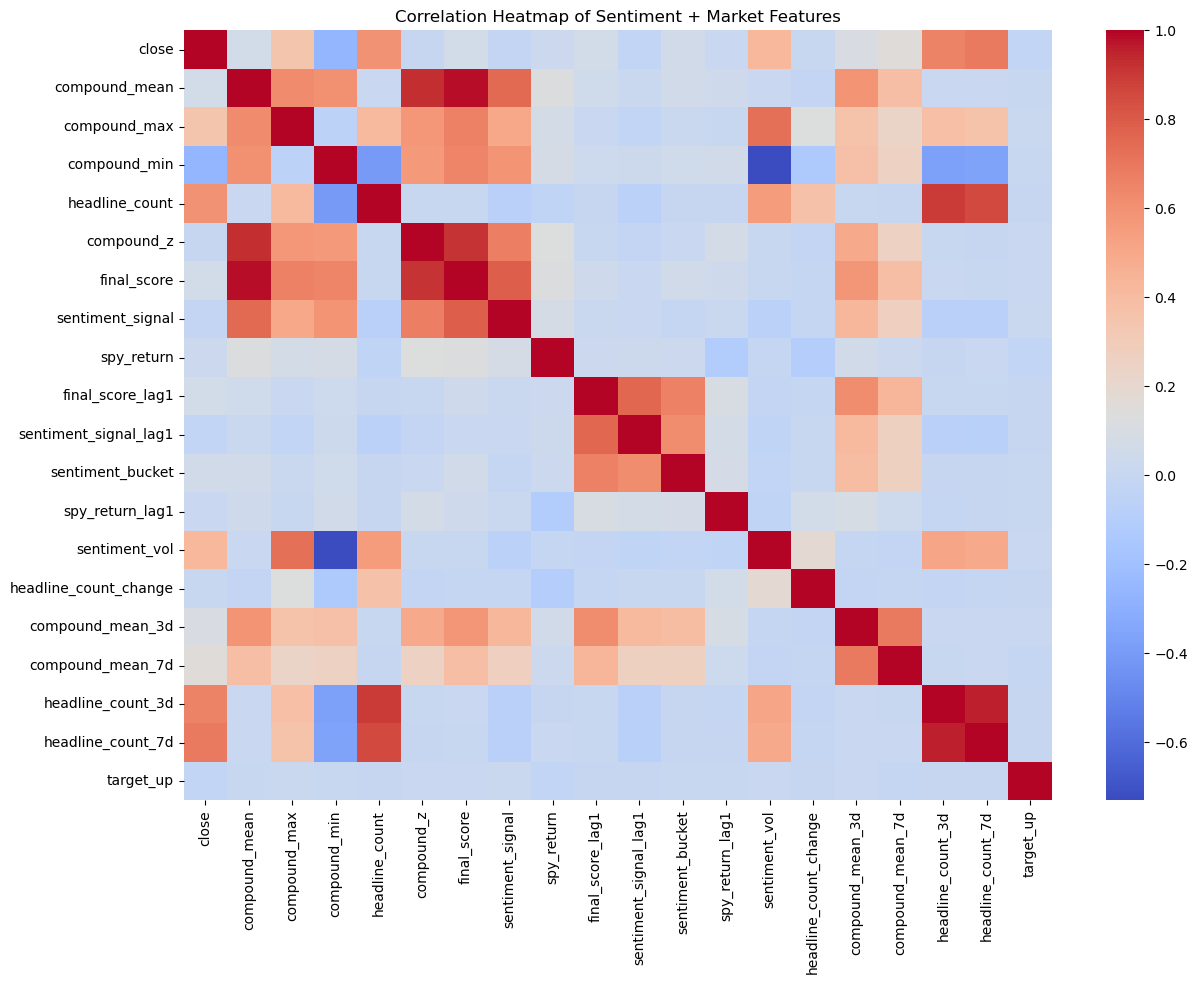

In [284]:
# Only include numeric columns
numeric_df = sentiment_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Sentiment + Market Features")
plt.show()


Several sentiment measures exhibit strong internal consistency, such as the high correlations among compound_mean, compound_max, compound_min, and other compound-based metrics, reflecting that they capture similar underlying sentiment dynamics. Lagged sentiment variables also show moderate correlations with their contemporaneous counterparts, which is expected given the temporal structure of market news. Conversely, most features show only weak linear relationships with spy_return and the target variable target_up, which aligns with established financial literature noting that daily market direction is largely unpredictable in a linear sense. This does not imply the absence of prediction potential; rather, it suggests that any predictability is likely nonlinear or dependent on temporal patterns, precisely the types of relationships deep learning architectures like CNN–LSTM are designed to capture. Additionally, features related to headline volume and sentiment dispersion appear to behave independently of the core sentiment scores, indicating that they may contribute unique information to the modelling process.

## ACF/PACF

<Figure size 1200x400 with 0 Axes>

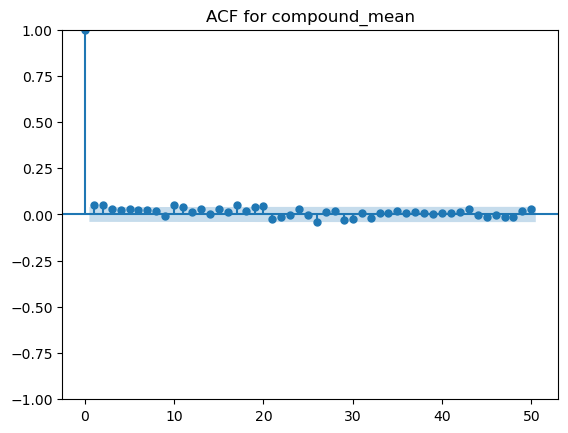

<Figure size 1200x400 with 0 Axes>

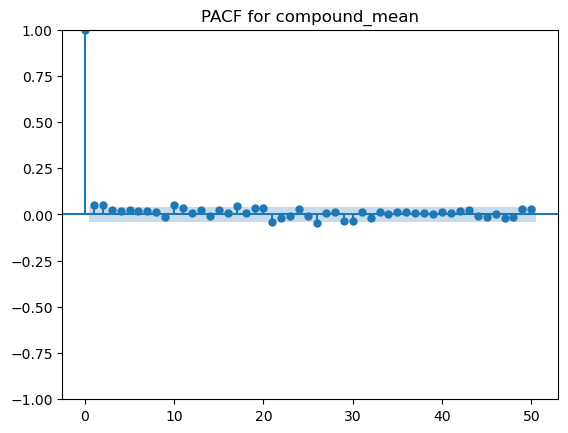

<Figure size 1200x400 with 0 Axes>

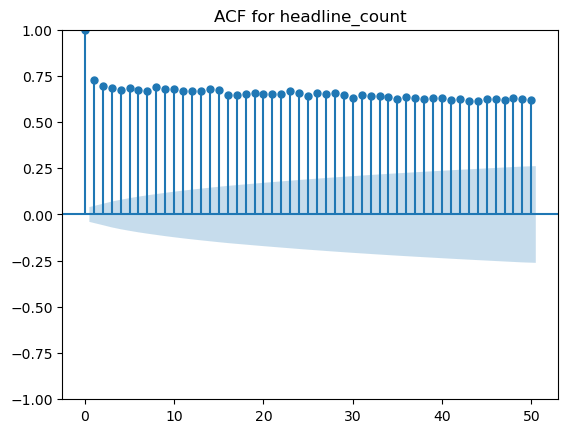

<Figure size 1200x400 with 0 Axes>

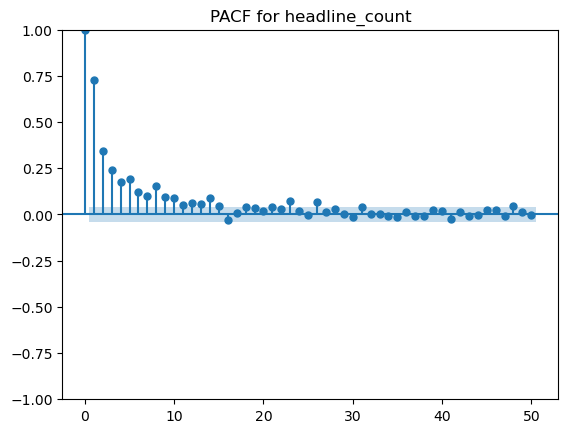

<Figure size 1200x400 with 0 Axes>

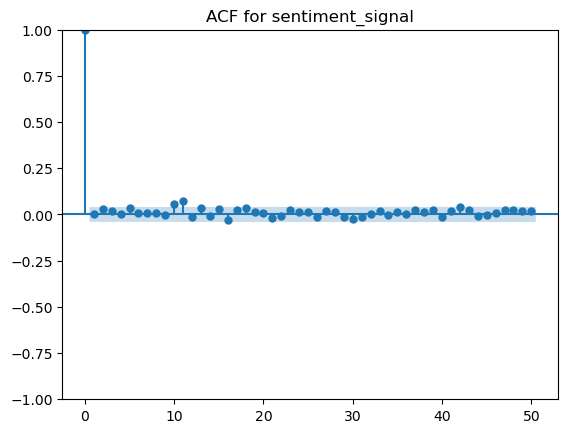

<Figure size 1200x400 with 0 Axes>

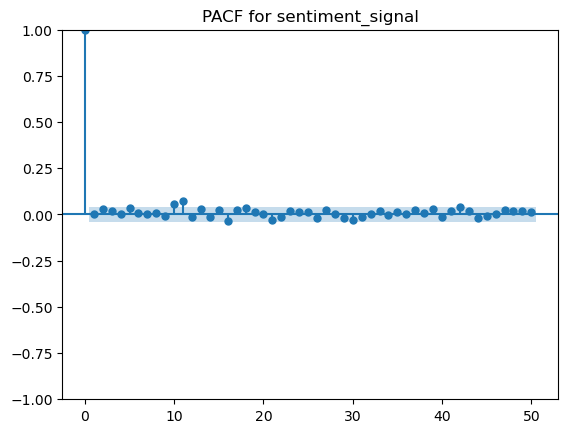

In [285]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

vars_to_plot = ['compound_mean', 'headline_count', 'sentiment_signal']

for col in vars_to_plot:
    plt.figure(figsize=(12, 4))
    plot_acf(sentiment_df[col].dropna(), lags=50)
    plt.title(f"ACF for {col}")
    plt.show()

    plt.figure(figsize=(12, 4))
    plot_pacf(sentiment_df[col].dropna(), lags=50)
    plt.title(f"PACF for {col}")
    plt.show()


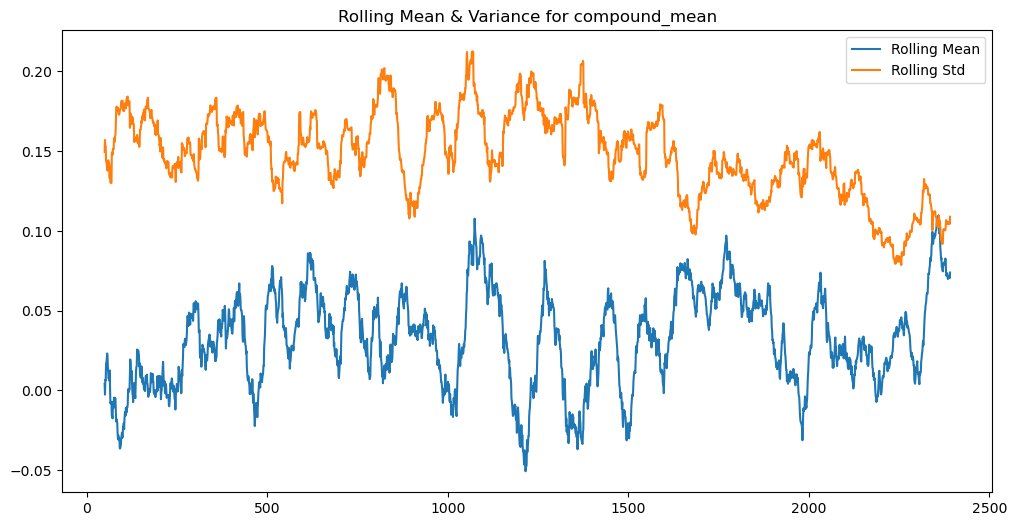

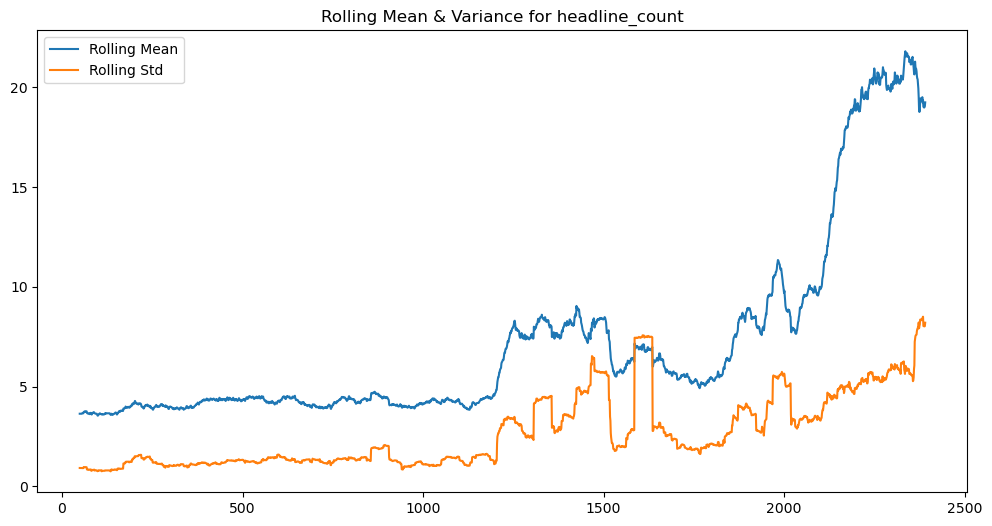

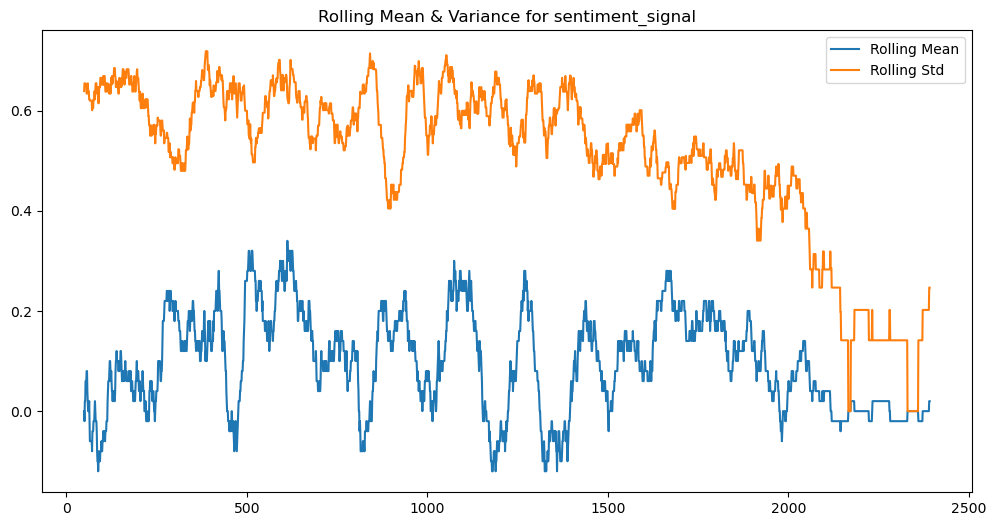

In [286]:
for col in ['compound_mean', 'headline_count', 'sentiment_signal']:
    plt.figure(figsize=(12,6))
    sentiment_df[col].rolling(50).mean().plot(label='Rolling Mean')
    sentiment_df[col].rolling(50).std().plot(label='Rolling Std')
    plt.title(f"Rolling Mean & Variance for {col}")
    plt.legend()
    plt.show()


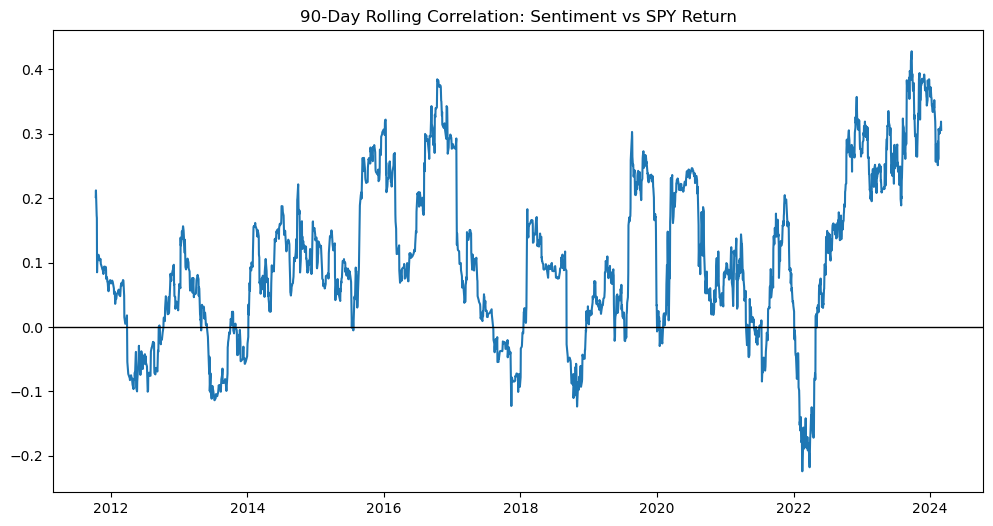

In [287]:
sentiment_df['rolling_corr'] = (
    sentiment_df['compound_mean'].rolling(90)
    .corr(sentiment_df['spy_return'])
)

plt.figure(figsize=(12,6))
plt.plot(sentiment_df['date'], sentiment_df['rolling_corr'])
plt.title("90-Day Rolling Correlation: Sentiment vs SPY Return")
plt.axhline(0, color='black', linewidth=1)
plt.show()


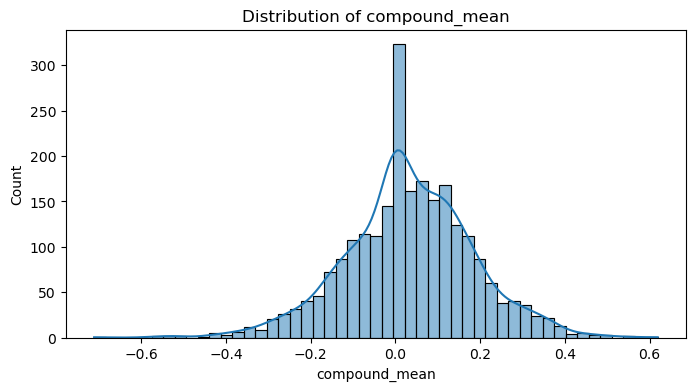

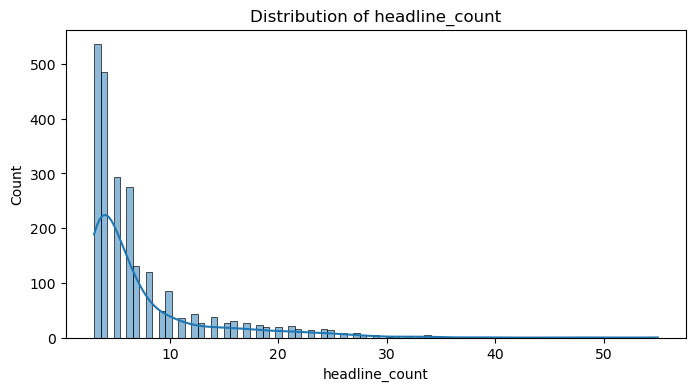

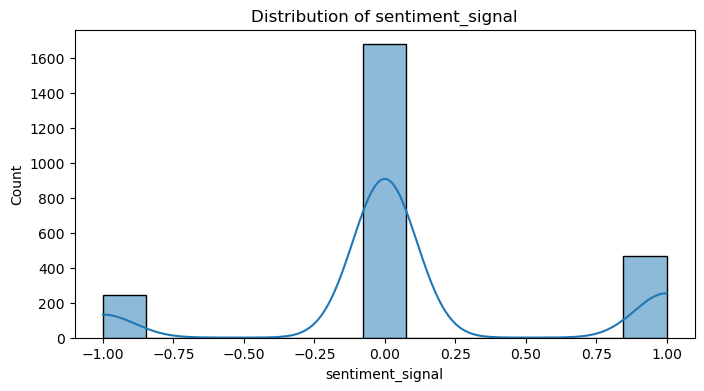

In [288]:
import seaborn as sns

for col in ['compound_mean', 'headline_count', 'sentiment_signal']:
    plt.figure(figsize=(8,4))
    sns.histplot(sentiment_df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


## Granger Causality Test

In [289]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(
    sentiment_df[['spy_return', 'compound_mean']], 
    maxlag=3, verbose=True
)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7078  , p=0.1914  , df_denom=2388, df_num=1
ssr based chi2 test:   chi2=1.7100  , p=0.1910  , df=1
likelihood ratio test: chi2=1.7094  , p=0.1911  , df=1
parameter F test:         F=1.7078  , p=0.1914  , df_denom=2388, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9893  , p=0.3720  , df_denom=2385, df_num=2
ssr based chi2 test:   chi2=1.9828  , p=0.3711  , df=2
likelihood ratio test: chi2=1.9820  , p=0.3712  , df=2
parameter F test:         F=0.9893  , p=0.3720  , df_denom=2385, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7379  , p=0.5294  , df_denom=2382, df_num=3
ssr based chi2 test:   chi2=2.2202  , p=0.5280  , df=3
likelihood ratio test: chi2=2.2192  , p=0.5282  , df=3
parameter F test:         F=0.7379  , p=0.5294  , df_denom=2382, df_num=3


c:\Users\malcolm\anaconda3\envs\fins3666\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (1.7078365303624716, 0.191392142572487, 2388.0, 1),
   'ssr_chi2test': (1.7099820536418215, 0.19098769896435114, 1),
   'lrtest': (1.7093708773027174, 0.19106701629862366, 1),
   'params_ftest': (1.7078365303634653, 0.19139214257239598, 2388.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9893311766311299, 0.37197783302120824, 2385.0, 2),
   'ssr_chi2test': (1.9828104923676315, 0.3710549010025744, 2),
   'lrtest': (1.9819884496246232, 0.37120744384392435, 2),
   'params_ftest': (0.9893311766311239, 0.37197783302120824, 2385.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.7379041975167804, 0.5293630910570408, 2382.0, 3),
   'ssr_chi2test': (2.220218045173285, 0.5279770336994889, 3),
   'lrtest': (2.2191870036840555, 0.5281790243724394, 3),
   'params_ftest': (0.7379041975170931, 0.5293630910568328, 2382.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.

The Granger causality test is done between the sentiment feature and next-day returns across lag lengths of one to three days. Across all specifications, the p-values remained well above conventional significance thresholds (for example, p = 0.19 for lag 1, p = 0.37 for lag 2, and p = 0.53 for lag 3). These results indicate that, in a linear forecasting framework, past sentiment values do not Granger-cause SPY returns. This outcome is consistent with the broader empirical finance literature, where daily returns typically display weak or nonexistent linear predictability.

## Mutual Information Test

In [290]:
# Remove unusable rows BEFORE splitting
clean_df = sentiment_df.drop(columns=['headline']).dropna().copy()

# X = features
X = clean_df.drop(columns=['target_up', 'date'])

# Keep only numeric
X = X.select_dtypes(include=['float64', 'int64', 'int32', 'Int64'])

# Convert pandas Int64 → int32
for col in X.columns:
    if str(X[col].dtype) == "Int64":
        X[col] = X[col].astype('int32')

# y = target
y = clean_df['target_up'].astype(int)



In [291]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X, y, discrete_features='auto')

mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi_series


final_score_lag1         0.023830
final_score              0.010695
headline_count           0.010278
spy_return_lag1          0.010269
spy_return               0.008061
too_few_headlines        0.006207
close                    0.006146
headline_count_change    0.005053
sentiment_signal_lag1    0.005049
compound_z               0.000459
conflicting              0.000000
sentiment_signal         0.000000
compound_min             0.000000
compound_mean            0.000000
sentiment_bucket         0.000000
compound_max             0.000000
sentiment_vol            0.000000
compound_mean_3d         0.000000
compound_mean_7d         0.000000
headline_count_3d        0.000000
headline_count_7d        0.000000
rolling_corr             0.000000
dtype: float64

In [292]:
from statsmodels.tsa.stattools import adfuller

for col in ['compound_mean','headline_count','sentiment_signal']:
    result = adfuller(sentiment_df[col].dropna())
    print(col, result[1])   # p-value


compound_mean 0.0
headline_count 0.8895299366559755
sentiment_signal 3.2624702069639427e-23


The ADF test was applied to key sentiment variables to evaluate their time-series properties, revealing that compound_mean and sentiment_signal are stationary while headline_count is non-stationary due to long-run growth in news volume. Although stationarity is not a requirement for deep learning models, these results provide useful insight into the underlying behaviour of the sentiment features over time.

## KPSS Test

In [293]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Critical Values: {critical_values}')

for col in ['compound_mean', 'headline_count', 'sentiment_signal']:
    print(f"\n--- KPSS Test for {col} ---")
    try:
        kpss_test(sentiment_df[col].dropna(), regression='c')
    except:
        print("Error: KPSS test not applicable.")



--- KPSS Test for compound_mean ---
KPSS Statistic: 0.34695027276290175
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

--- KPSS Test for headline_count ---
KPSS Statistic: 5.010786090844002
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

--- KPSS Test for sentiment_signal ---
KPSS Statistic: 0.5005929807018845
p-value: 0.041533112454530514
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\malcolm\AppData\Local\Temp\ipykernel_8972\2891606225.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
C:\Users\malcolm\AppData\Local\Temp\ipykernel_8972\2891606225.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


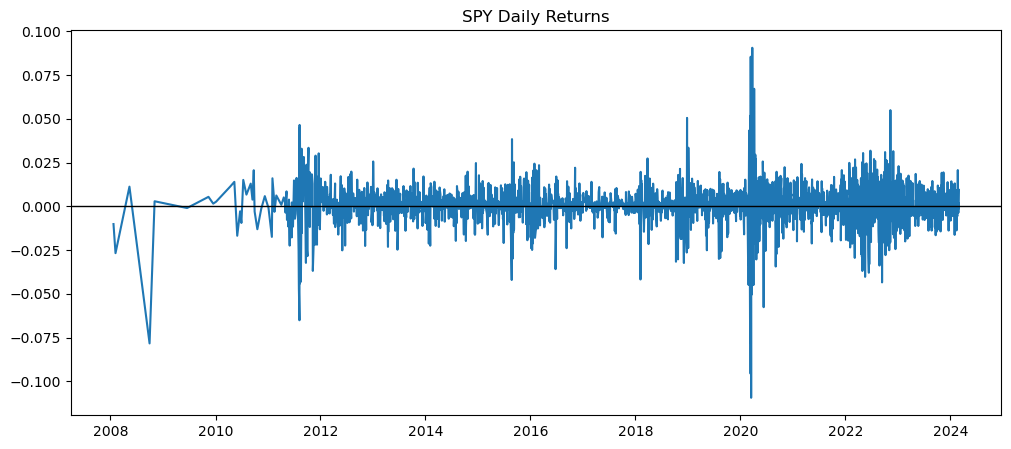

In [294]:
plt.figure(figsize=(12,5))
plt.plot(sentiment_df['date'], sentiment_df['spy_return'])
plt.title('SPY Daily Returns')
plt.axhline(0, color='black', linewidth=1)
plt.show()


## Feature Preprocessing


In [295]:
# Start with cleaned dataframe
df = sentiment_df.copy()


features_to_drop_mi = [
    'compound_mean',
    'compound_min',
    'compound_mean_3d',
    'compound_mean_7d',
    'headline_count',
    'headline_count_7d',
    'headline_count_change',
    'sentiment_signal_lag1',
    'sentiment_vol',
    'rolling_corr',
    'conflicting',
    'compound_z',              # almost zero MI
]

# Drop only if present
df = df.drop(columns=[col for col in features_to_drop_mi if col in df.columns])




redundant_features = [
    'final_score_lag1',   # kept (useful)
    'final_score',        # kept
    # no action here because MI already handled most
]



selected_features = [
    'sentiment_bucket',
    'final_score',
    'final_score_lag1',
    'compound_max',
    'spy_return',
    'spy_return_lag1',
    'headline_count_3d',
    'close',
    'sentiment_signal',
]

selected_features = [f for f in selected_features if f in df.columns]

print("FINAL FEATURE SET:")
print(selected_features)

# Filter final dataset
X_final = df[selected_features].copy()
y_final = df['target_up'].astype(int)

print("\nShapes:")
print("X_final:", X_final.shape)
print("y_final:", y_final.shape)


FINAL FEATURE SET:
['sentiment_bucket', 'final_score', 'final_score_lag1', 'compound_max', 'spy_return', 'spy_return_lag1', 'headline_count_3d', 'close', 'sentiment_signal']

Shapes:
X_final: (2392, 9)
y_final: (2392,)


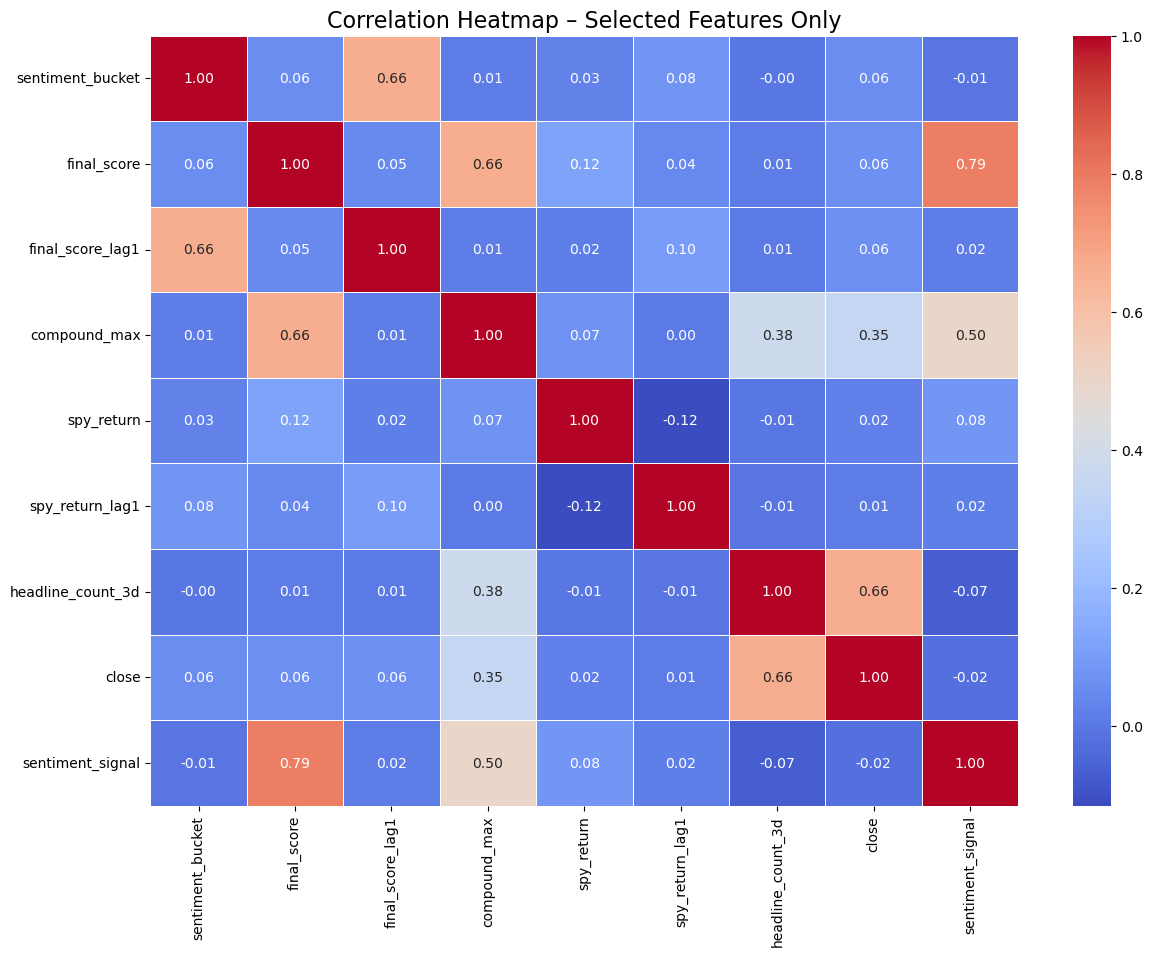

In [296]:
selected_features = [
    'sentiment_bucket','final_score','final_score_lag1','compound_max',
    'spy_return','spy_return_lag1','headline_count_3d','close','sentiment_signal'
]

plt.figure(figsize=(14, 10))
sns.heatmap(
    sentiment_df[selected_features].corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap – Selected Features Only", fontsize=16)
plt.show()


# Train Test Split

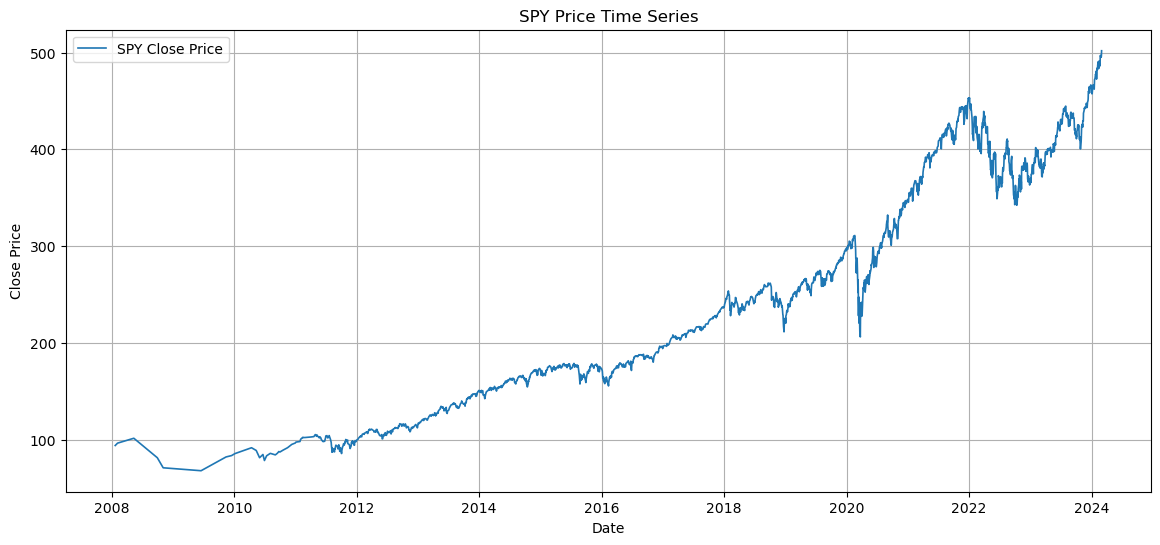

In [297]:
plt.figure(figsize=(14,6))

plt.plot(sentiment_df['date'], sentiment_df['close'], label='SPY Close Price', linewidth=1.2)

plt.title("SPY Price Time Series")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()

plt.show()


In [298]:
splits = []

i = 0
while i + train_size < len(df):

    train_start = i
    train_end   = min(i + train_size, len(df))

    val_start   = max(train_end - val_size, train_start)
    val_end     = train_end

    test_start  = train_end
    test_end    = min(train_end + test_size, len(df))

    # Break if test window has no data
    if test_start >= len(df):
        break

    splits.append((train_start, train_end, val_start, val_end, test_start, test_end))

    i += step_size     # move forward by 250 days


In [299]:
# Convert indices to calendar dates for readability
split_dates = []

for idx, (tr_s, tr_e, va_s, va_e, te_s, te_e) in enumerate(splits):
    split_dates.append({
        "Window": idx + 1,

        "Train Start": df['date'].iloc[tr_s].date(),
        "Train End":   df['date'].iloc[tr_e - 1].date(),

        "Val Start":   df['date'].iloc[va_s].date(),
        "Val End":     df['date'].iloc[va_e - 1].date(),

        "Test Start":  df['date'].iloc[te_s].date(),
        "Test End":    df['date'].iloc[te_e - 1].date(),
    })

# Convert to DataFrame
split_dates_df = pd.DataFrame(split_dates)

# Display all windows
split_dates_df


,Window,Train Start,Train End,Val Start,Val End,Test Start,Test End
0,1,2008-01-22,2015-12-17,2015-01-20,2015-12-17,2015-12-18,2017-08-16
1,2,2012-11-23,2017-08-16,2016-08-04,2017-08-16,2017-08-17,2019-03-11
2,3,2014-06-24,2019-03-11,2018-04-23,2019-03-11,2019-03-13,2020-05-04
3,4,2015-12-18,2020-05-04,2019-09-09,2020-05-04,2020-05-05,2021-07-14
4,5,2017-08-17,2021-07-14,2020-10-20,2021-07-14,2021-07-15,2022-07-28
5,6,2019-03-13,2022-07-28,2021-12-20,2022-07-28,2022-07-29,2023-08-08
6,7,2020-05-05,2023-08-08,2022-12-22,2023-08-08,2023-08-09,2024-03-01


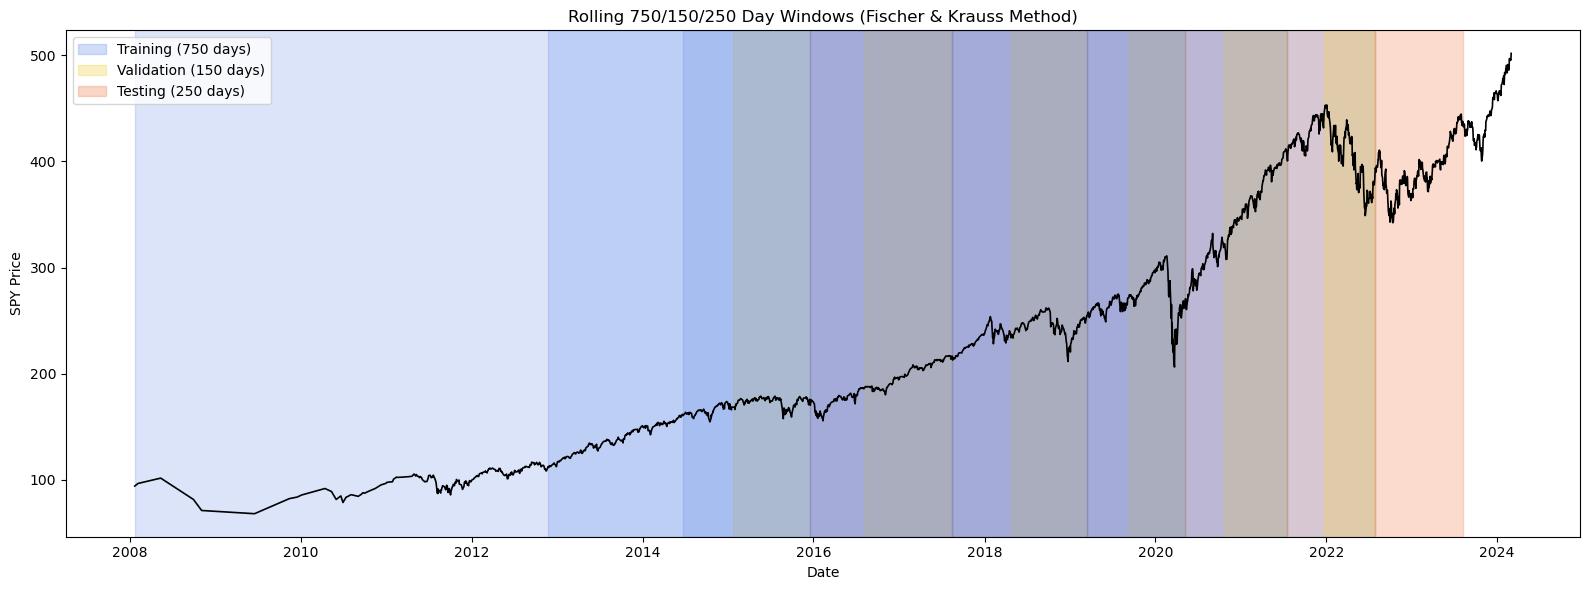

Total rolling windows: 7


In [301]:
plt.figure(figsize=(16,6))
plt.plot(df['date'], df['close'], color="black", linewidth=1.2, label="SPY Close Price")

train_color = "#4B7BE5"   # soft blue
val_color   = "#F3D250"   # warm yellow
test_color  = "#F08A5D"   # coral

for (tr_s, tr_e, va_s, va_e, te_s, te_e) in splits:
    
    # Skip partial windows (test_end must be strictly inside range)
    if te_e >= len(df):
        continue
    
    plt.axvspan(df['date'].iloc[tr_s], df['date'].iloc[tr_e],
                color=train_color, alpha=0.20)

    plt.axvspan(df['date'].iloc[va_s], df['date'].iloc[va_e],
                color=val_color, alpha=0.30)

    plt.axvspan(df['date'].iloc[te_s], df['date'].iloc[te_e],
                color=test_color, alpha=0.30)


# Legend patches
train_patch = mpatches.Patch(color=train_color,  alpha=0.25, label="Training (750 days)")
val_patch   = mpatches.Patch(color=val_color,    alpha=0.35, label="Validation (150 days)")
test_patch  = mpatches.Patch(color=test_color,   alpha=0.35, label="Testing (250 days)")

plt.legend(handles=[train_patch, val_patch, test_patch],
           loc="upper left", frameon=True)

plt.title("Rolling 750/150/250 Day Windows (Fischer & Krauss Method)")
plt.xlabel("Date")
plt.ylabel("SPY Price")

plt.tight_layout()
plt.show()

print("Total rolling windows:", len(splits))

In [ ]:
# sequence maker ---
def make_sequences(features_arr, target_arr, seq_len):
    X, y = [], []
    for i in range(seq_len, len(features_arr)):
        X.append(features_arr[i-seq_len:i])
        y.append(target_arr[i])
    return np.array(X), np.array(y)


# CNN-LSTM model
def build_cnn_lstm(input_shape):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.metrics import AUC

    model = Sequential()
    
    model.add(Conv1D(64, 3, padding='causal', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    model.add(Conv1D(64, 3, padding='causal', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    model.add(LSTM(64))
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))  # up/down probability

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(1e-3),
        metrics=['accuracy', AUC(name='auc')]
    )

    return model


In [303]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

seq_len = 30
results = []

for w, (tr_s, tr_e, va_s, va_e, te_s, te_e) in enumerate(splits):

    print(f"\n🔵 Window {w+1}/{len(splits)}")
    print(f"Train: {tr_s}–{tr_e}, Val: {va_s}–{va_e}, Test: {te_s}–{te_e}")

    # Extract window slices
    train_df = df.iloc[tr_s:tr_e]
    val_df   = df.iloc[va_s:va_e]
    test_df  = df.iloc[te_s:te_e]

    # Targets
    y_train_raw = train_df['target_up'].astype(int).values
    y_val_raw   = val_df['target_up'].astype(int).values
    y_test_raw  = test_df['target_up'].astype(int).values

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_df[feature_cols])
    X_val_scaled   = scaler.transform(val_df[feature_cols])
    X_test_scaled  = scaler.transform(test_df[feature_cols])

    # Convert to sequences
    X_train, y_train = make_sequences(X_train_scaled, y_train_raw, seq_len)
    X_val,   y_val   = make_sequences(X_val_scaled,   y_val_raw,   seq_len)
    X_test,  y_test  = make_sequences(X_test_scaled,  y_test_raw,  seq_len)

    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_cnn_lstm(input_shape)

    # Early stopping
    early = EarlyStopping(monitor='val_auc', mode='max', patience=8,
                          restore_best_weights=True, verbose=0)

    # Fit
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early],
        verbose=0
    )

    # Evaluate on test
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)

    print(f" → Test AUC: {test_auc:.3f} | Test Acc: {test_acc:.3f}")

    # Evaluate
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)

    # Predict probabilities on the test sequences
    probs = model.predict(X_test).flatten()

    # Align dates and returns to the SEQUENCE END
    test_dates = test_df['date'].iloc[seq_len:].values
    test_next_returns = test_df['spy_return'].iloc[seq_len:].values
    test_actuals = y_test

    # Store predictions window-by-window
    window_results = pd.DataFrame({
        "date": test_dates,
        "prob_up": probs,
        "actual_up": test_actuals,
        "next_return": test_next_returns,
        "window": w
    })

    results.append({
        "window": w,
        "train_range": (tr_s, tr_e),
        "val_range": (va_s, va_e),
        "test_range": (te_s, te_e),
        "test_auc": float(test_auc),
        "test_acc": float(test_acc),
        "pred_df": window_results
    })




🔵 Window 1/7
Train: 0–750, Val: 600–750, Test: 750–1000
 → Test AUC: 0.517 | Test Acc: 0.527
7/7 [==============================] - 0s 2ms/step

🔵 Window 2/7
Train: 250–1000, Val: 850–1000, Test: 1000–1250
 → Test AUC: 0.523 | Test Acc: 0.536
7/7 [==============================] - 0s 2ms/step

🔵 Window 3/7
Train: 500–1250, Val: 1100–1250, Test: 1250–1500
 → Test AUC: 0.492 | Test Acc: 0.527
7/7 [==============================] - 0s 2ms/step

🔵 Window 4/7
Train: 750–1500, Val: 1350–1500, Test: 1500–1750
 → Test AUC: 0.478 | Test Acc: 0.514
7/7 [==============================] - 0s 2ms/step

🔵 Window 5/7
Train: 1000–1750, Val: 1600–1750, Test: 1750–2000
 → Test AUC: 0.530 | Test Acc: 0.505
7/7 [==============================] - 0s 2ms/step

🔵 Window 6/7
Train: 1250–2000, Val: 1850–2000, Test: 2000–2250
 → Test AUC: 0.474 | Test Acc: 0.500
7/7 [==============================] - 0s 2ms/step

🔵 Window 7/7
Train: 1500–2250, Val: 2100–2250, Test: 2250–2392
 → Test AUC: 0.461 | Test Acc: 0.48

# Model Results

In [316]:
results_df = pd.DataFrame([{
    "window": r["window"] + 1,
    "train_start": r["train_range"][0],
    "train_end": r["train_range"][1],
    "val_start": r["val_range"][0],
    "val_end": r["val_range"][1],
    "test_start": r["test_range"][0],
    "test_end": r["test_range"][1],
    "test_auc": r["test_auc"],
    "test_acc": r["test_acc"]
} for r in results])

results_df


,window,train_start,train_end,val_start,val_end,test_start,test_end,test_auc,test_acc
0,1,0,750,600,750,750,1000,0.516887,0.527273
1,2,250,1000,850,1000,1000,1250,0.522542,0.536364
2,3,500,1250,1100,1250,1250,1500,0.492289,0.527273
3,4,750,1500,1350,1500,1500,1750,0.477660,0.513636
4,5,1000,1750,1600,1750,1750,2000,0.529755,0.504545
5,6,1250,2000,1850,2000,2000,2250,0.473989,0.500000
6,7,1500,2250,2100,2250,2250,2392,0.461028,0.482143


In [304]:
# Combine all prediction dataframes
all_preds = pd.concat([r["pred_df"] for r in results], ignore_index=True)

# Sort chronologically (some windows overlap)
all_preds = all_preds.sort_values("date").reset_index(drop=True)


In [305]:
# Buy if model predicts > 0.5 probability that SPY will rise tomorrow
all_preds["signal"] = (all_preds["prob_up"] > 0.5).astype(int)


In [306]:
all_preds["strategy_return"] = all_preds["signal"] * all_preds["next_return"]


In [307]:
all_preds["buy_hold"] = all_preds["next_return"].cumsum()


In [308]:
all_preds["strategy_cum"] = all_preds["strategy_return"].cumsum()


# Simple Backtest

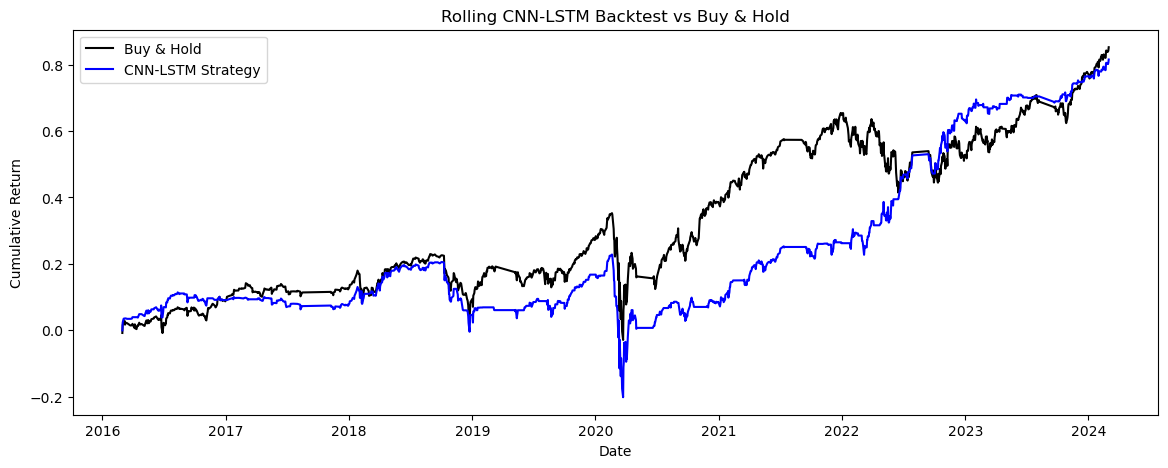

In [309]:
plt.figure(figsize=(14,5))
plt.plot(all_preds["date"], all_preds["buy_hold"], label="Buy & Hold", color="black")
plt.plot(all_preds["date"], all_preds["strategy_cum"], label="CNN-LSTM Strategy", color="blue")
plt.title("Rolling CNN-LSTM Backtest vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


# Export results

In [ ]:
# Select only the required columns
export_df = all_preds[["date", "prob_up", "actual_up", "next_return", "window"]].copy()

# Save to CSV
export_df.to_csv("refined_cnn_lstm_predictionsl.csv", index=False)
